In [1]:
import pandas as pd
import numpy as np
from time import time
import datetime
import lightgbm as lgb
import gc, warnings
gc.collect()

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, confusion_matrix, accuracy_score
from sklearn.metrics import roc_auc_score, f1_score, roc_curve, auc,precision_recall_curve
from scipy import interp
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [2]:
traintr = pd.read_csv('input/train_transaction.csv.zip')
trainid = pd.read_csv('input/train_identity.csv.zip')
testtr  = pd.read_csv('input/test_transaction.csv.zip')
testid  = pd.read_csv('input/test_identity.csv.zip')

In [3]:
# For each categorical variable, we'd like to experiment with
# the count of appearances within that day's hour
# This will only work if the distributions (counts) are similar in train + test

START_DATE     = '2017-12-01'
startdate      = datetime.datetime.strptime(START_DATE, '%Y-%m-%d')
traintr['tdt']    = traintr['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds = x)))
traintr['thour']  = traintr.tdt.dt.hour
traintr['tdate']  = traintr.tdt.dt.date

testtr['tdt']    = testtr['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds = x)))
testtr['thour']  = testtr.tdt.dt.hour
testtr['tdate']  = testtr.tdt.dt.date

In [4]:
data = traintr.append(testtr, sort=False)
data.reset_index(drop=True, inplace=True)
trx_size = traintr.shape[0]

In [5]:
seed = 123

# Fast FI!
params = {
    # Simple trees
    'max_depth': 16,
    'num_leaves': 4,
#     'bagging_fraction': 0.80,
    
    'objective': 'binary',
    'save_binary': True,
    'seed': seed,
    'feature_fraction_seed': seed,
    'bagging_seed': seed,
    'drop_seed': seed,
    'data_random_seed': seed,
    'boosting_type': 'gbdt',
    'boost_from_average': True,
    'metric':'auc',
    'verbosity': -1,
    'verbose': -1,
    'is_unbalance': False,
    #'scale_pos_weight':2,
}

This is a very simple method we can use to test covariate shift between train + test. It uses randomforest rather than GBDT. So the results might underestimate the CVS, beware!


In [ ]:
def test_cvs(data, feature, plot=False):
    global trx_size
    
    data['covariate_shift'] = (np.arange(data.shape[0]) >= trx_size).astype(np.uint8)
    peek = data[~data[feature].isna()]
    
    if plot:
        f, ax = plt.subplots(2,2,figsize=(14,8))
        ax[0, 0].set_title('Train')
        ax[0, 1].set_title('Test')
        ax[0, 0].hist(peek[peek.index<trx_size][feature],100)
        ax[0, 1].hist(peek[peek.index>=trx_size][feature],100)
        # TODO: Plot against TIME:
        ax[1, 0].scatter(peek[peek.index<trx_size].TransactionDT, peek[peek.index<trx_size][feature], s=0.1, alpha=0.1)
        ax[1, 1].scatter(peek[peek.index>=trx_size].TransactionDT, peek[peek.index>=trx_size][feature], s=0.1, alpha=0.1)
        plt.show()
    
    # Test covariate shift:
    index_trn = np.random.choice(np.arange(peek.shape[0]), size=peek.shape[0]//2)
    index_val = list(set(np.arange(peek.shape[0])) - set(index_trn))
    
    clf = RandomForestClassifier(n_estimators=10, max_depth=15, random_state=1237, n_jobs=-1)
    clf.fit(peek[feature].iloc[index_trn].values.reshape(-1,1), peek.covariate_shift.iloc[index_trn]) 

    y_true = peek.iloc[index_val].covariate_shift.values.flatten()
    y_pred = clf.predict(peek[feature].iloc[index_val].values.reshape(-1,1))
    
    del data['covariate_shift']
    return roc_auc_score(y_true, y_pred)

Simple method allows us to evaluate the RoC of a set of features. Also returns things like gain, splits, etc...

In [1]:
def experiment(data, features, params, runs=3, train_frac=0.75, seed=123, expnum=0, retoof=False, max_trees=25):
    global trx_size
    
    # Feature Selection Validator
    recalls    = []
    roc_aucs   = []
    f1_scores  = []
    accuracies = []
    precisions = []
    all_y_true = []
    all_y_pred = []
    tprs = []

    fi = pd.DataFrame()
    fi['feature'] = features
    fi['expnum'] = expnum
    
    oof = np.zeros(trx_size) # todo: logic for last fold

    # TODO: Use our validation strategy here rather than % split
    index_trn = np.arange(int(train_frac*trx_size))
    index_val = np.arange(int(train_frac*trx_size),trx_size)
    
    trn_data = lgb.Dataset(data[features].iloc[index_trn], label=data.isFraud.iloc[index_trn])
    val_data = lgb.Dataset(data[features].iloc[index_val], label=data.isFraud.iloc[index_val])

    params = params.copy()
    for run in range(runs):
        params['seed'] = seed + run
        params['feature_fraction_seed'] = seed + run
        params['bagging_seed'] = seed + run
        params['drop_seed'] = seed + run
        params['data_random_seed'] = seed + run

        clf = lgb.train(
            params,
            trn_data,
            max_trees,
            valid_sets = [trn_data, val_data],
            verbose_eval=600,
            early_stopping_rounds=5
        )
        
        # Scores
        y_true = data.iloc[index_val].isFraud.values
        y_pred = clf.predict(data[features].iloc[index_val])
        all_y_true.append(y_true)
        all_y_pred.append(y_pred)
        
        oof[index_val] = y_pred
        
        warnings.filterwarnings("ignore")
        accuracies.append(accuracy_score(y_true, y_pred.round()))
        recalls.append(recall_score(y_true, y_pred.round()))
        precisions.append(precision_score(y_true, y_pred.round()))
        f1_scores.append(f1_score(y_true, y_pred.round()))
        roc_aucs.append(clf.best_score['valid_1']['auc'])
        warnings.filterwarnings("default")
        
        fi['gain_run_{}'.format(run + 1)] = clf.feature_importance(importance_type='gain')
        fi['split_run_{}'.format(run + 1)] = clf.feature_importance(importance_type='split')
        fi['iter_run_{}'.format(run + 1)] = clf.best_iteration
        fi['roc_run_{}'.format(run + 1)] = clf.best_score['valid_1']['auc']

    fi['gain'] = fi[[f for f in fi if 'gain_run_' in f]].mean(axis=1)
    fi['split'] = fi[[f for f in fi if 'split_run_' in f]].mean(axis=1)
    fi['iter'] = fi[[f for f in fi if 'iter_run_' in f]].mean(axis=1)
    fi['roc'] = fi[[f for f in fi if 'roc_run_' in f]].mean(axis=1)

    if retoof:
        return oof, fi, np.mean(roc_aucs)
    
    return fi, np.mean(roc_aucs)

In [7]:
all_cols = [f for f in data.columns if f not in ['TransactionID', 'TransactionDT', 'isFraud', 'tdt', 'tdate']]
ready_cols = []
for f in all_cols:
    # For string variables, encode to label and count encode.
    if data[f].dtype!='O':
        ready_cols.append(f)
        continue

    mapper = {key:val for val,key in enumerate(data[f].unique())}
    if np.nan in mapper: mapper[np.nan] = np.nan # Keep Nans Nan
        
    # For non-numeric categorical variables, try both Label + CountEncode. Whatever works best..
    data['LE_' + f] = data[f].map(mapper)
    data['CE_' + f] = data[f].map(data[f].value_counts(dropna=True)) # Keep nans nan here as well...
    ready_cols += ['CE_' + f, 'LE_' + f]

len(ready_cols), ready_cols

(406,
 ['TransactionAmt',
  'CE_ProductCD',
  'LE_ProductCD',
  'card1',
  'card2',
  'card3',
  'CE_card4',
  'LE_card4',
  'card5',
  'CE_card6',
  'LE_card6',
  'addr1',
  'addr2',
  'dist1',
  'dist2',
  'CE_P_emaildomain',
  'LE_P_emaildomain',
  'CE_R_emaildomain',
  'LE_R_emaildomain',
  'C1',
  'C2',
  'C3',
  'C4',
  'C5',
  'C6',
  'C7',
  'C8',
  'C9',
  'C10',
  'C11',
  'C12',
  'C13',
  'C14',
  'D1',
  'D2',
  'D3',
  'D4',
  'D5',
  'D6',
  'D7',
  'D8',
  'D9',
  'D10',
  'D11',
  'D12',
  'D13',
  'D14',
  'D15',
  'CE_M1',
  'LE_M1',
  'CE_M2',
  'LE_M2',
  'CE_M3',
  'LE_M3',
  'CE_M4',
  'LE_M4',
  'CE_M5',
  'LE_M5',
  'CE_M6',
  'LE_M6',
  'CE_M7',
  'LE_M7',
  'CE_M8',
  'LE_M8',
  'CE_M9',
  'LE_M9',
  'V1',
  'V2',
  'V3',
  'V4',
  'V5',
  'V6',
  'V7',
  'V8',
  'V9',
  'V10',
  'V11',
  'V12',
  'V13',
  'V14',
  'V15',
  'V16',
  'V17',
  'V18',
  'V19',
  'V20',
  'V21',
  'V22',
  'V23',
  'V24',
  'V25',
  'V26',
  'V27',
  'V28',
  'V29',
  'V30',
  'V

In [8]:
trpart = data[data.index<trx_size]
tepart = data[data.index>=trx_size]

results = []
for i, f in enumerate(ready_cols):
    print(i+1, '/', len(ready_cols))

    # CVS by decision tree...
    cvs = test_cvs(data, f)
    
    cnt_nan_train = tepart[f].isna().sum() / traintr.shape[0]
    cnt_nan_test = tepart[f].isna().sum() / testtr.shape[0]
    nunique = data[f].nunique()
    
    vcs = data[f].value_counts()
    most_freq_val  = vcs.index[0]
    most_freq_perc = vcs.iloc[0] / data.shape[0]
    least_freq_cnt = vcs.iloc[-1]
    
    tr = data[data.index<trx_size][[f,'isFraud']]
    corr_tdt = data[[f,'TransactionDT']].corr()[f].TransactionDT
    corr_target = tr.corr()[f].isFraud
    
    exper = experiment(
        tr,
        [f],
        params,
        runs=1,
        train_frac=0.7,
        seed=123,
        expnum=1
    )[0]
    
    results.append([
        f, cvs, nunique,
        cnt_nan_train, cnt_nan_test, most_freq_perc, most_freq_val, least_freq_cnt,
        exper.gain.iloc[0], exper.split.iloc[0], exper.roc.iloc[0], exper.iter.iloc[0], 
        corr_target, corr_tdt
    ])
    
results = pd.DataFrame(results, columns=[
    'col', 'CVS', 'NUnique', 'NANTrainR', 'NANTestR',
    'MFreqR', 'MFreqV', 'LFreqCnt',
    'Gain70','Split70','Roc70','Iter70',
    'YCorr', 'DTCorr'
])
results['GPS70'] = results.Gain70 / results.Split70

1 / 406
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[19]	training's auc: 0.62763	valid_1's auc: 0.614237
2 / 406
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[1]	training's auc: 0.673654	valid_1's auc: 0.691175
3 / 406
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[3]	training's auc: 0.673919	valid_1's auc: 0.691122
4 / 406
Training until validation scores don't improve for 5 rounds.
Did not meet early stopping. Best iteration is:
[25]	training's auc: 0.610463	valid_1's auc: 0.587967
5 / 406
Training until validation scores don't improve for 5 rounds.
Did not meet early stopping. Best iteration is:
[25]	training's auc: 0.633753	valid_1's auc: 0.618072
6 / 406
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[4]	training's auc: 0.634555	valid_1's auc: 0.649787
7 / 406
Training until validat

Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[1]	training's auc: 0.609721	valid_1's auc: 0.680202
54 / 406
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[1]	training's auc: 0.609721	valid_1's auc: 0.680202
55 / 406
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[1]	training's auc: 0.667297	valid_1's auc: 0.677367
56 / 406
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[1]	training's auc: 0.667297	valid_1's auc: 0.677367
57 / 406
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[1]	training's auc: 0.532278	valid_1's auc: 0.520311
58 / 406
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[1]	training's auc: 0.532278	valid_1's auc: 0.520311
59 / 406
Training until validation scores don't improve for 5

Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[1]	training's auc: 0.65943	valid_1's auc: 0.691362
106 / 406
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[2]	training's auc: 0.66121	valid_1's auc: 0.692386
107 / 406
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[1]	training's auc: 0.50165	valid_1's auc: 0.511946
108 / 406
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[1]	training's auc: 0.654658	valid_1's auc: 0.688561
109 / 406
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[2]	training's auc: 0.656247	valid_1's auc: 0.689976
110 / 406
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[7]	training's auc: 0.609952	valid_1's auc: 0.626896
111 / 406
Training until validation scores don't improve fo

Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[1]	training's auc: 0.640959	valid_1's auc: 0.636576
158 / 406
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[1]	training's auc: 0.66899	valid_1's auc: 0.694163
159 / 406
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[5]	training's auc: 0.669888	valid_1's auc: 0.694707
160 / 406
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[1]	training's auc: 0.680586	valid_1's auc: 0.704054
161 / 406
Training until validation scores don't improve for 5 rounds.
Did not meet early stopping. Best iteration is:
[24]	training's auc: 0.587488	valid_1's auc: 0.585311
162 / 406
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[16]	training's auc: 0.536962	valid_1's auc: 0.526331
163 / 406
Training until validation scores

Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[3]	training's auc: 0.534804	valid_1's auc: 0.536705
210 / 406
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[1]	training's auc: 0.532371	valid_1's auc: 0.5224
211 / 406
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[2]	training's auc: 0.538485	valid_1's auc: 0.527833
212 / 406
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[1]	training's auc: 0.526078	valid_1's auc: 0.522054
213 / 406
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[1]	training's auc: 0.529006	valid_1's auc: 0.522166
214 / 406
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[1]	training's auc: 0.528678	valid_1's auc: 0.512628
215 / 406
Training until validation scores don't improve f

Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[2]	training's auc: 0.653904	valid_1's auc: 0.679758
262 / 406
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[1]	training's auc: 0.653853	valid_1's auc: 0.67405
263 / 406
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[3]	training's auc: 0.654241	valid_1's auc: 0.677887
264 / 406
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[2]	training's auc: 0.654944	valid_1's auc: 0.678126
265 / 406
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[9]	training's auc: 0.672341	valid_1's auc: 0.689439
266 / 406
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[7]	training's auc: 0.672276	valid_1's auc: 0.691524
267 / 406
Training until validation scores don't improve 

Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[1]	training's auc: 0.639413	valid_1's auc: 0.667117
314 / 406
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[2]	training's auc: 0.641665	valid_1's auc: 0.669111
315 / 406
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[2]	training's auc: 0.640828	valid_1's auc: 0.666599
316 / 406
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[6]	training's auc: 0.654913	valid_1's auc: 0.674143
317 / 406
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[5]	training's auc: 0.656446	valid_1's auc: 0.675708
318 / 406
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[2]	training's auc: 0.639403	valid_1's auc: 0.66457
319 / 406
Training until validation scores don't improve 

Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[1]	training's auc: 0.518796	valid_1's auc: 0.506668
366 / 406
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[1]	training's auc: 0.513556	valid_1's auc: 0.510297
367 / 406
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[1]	training's auc: 0.517949	valid_1's auc: 0.514481
368 / 406
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[1]	training's auc: 0.652167	valid_1's auc: 0.671905
369 / 406
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[1]	training's auc: 0.657277	valid_1's auc: 0.675428
370 / 406
Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[7]	training's auc: 0.654967	valid_1's auc: 0.673367
371 / 406
Training until validation scores don't improve

In [9]:
results.sort_values(['Roc70'], ascending=False)

,col,CVS,NUnique,NANTrainR,NANTestR,MFreqR,MFreqV,LFreqCnt,Gain70,Split70,Roc70,Iter70,YCorr,DTCorr,GPS70
159,V94,0.507949,3,0.020458,0.023843,0.776303,0.0,18,10966.520264,2.0,0.704054,1.0,0.188407,0.032731,5483.260132
99,V34,0.514922,23,0.021318,0.024846,0.779786,0.0,1,10740.100571,3.0,0.702866,1.0,0.180301,0.052853,3580.033524
98,V33,0.511623,13,0.021318,0.024846,0.789384,0.0,1,10706.912949,3.0,0.699515,1.0,0.183486,0.045495,3568.970983
117,V52,0.509425,12,0.130142,0.151678,0.638929,0.0,1,26261.612976,6.0,0.698587,2.0,0.239469,0.031656,4376.935496
76,V11,0.500017,8,0.298909,0.348374,0.320882,0.0,2,3068.276772,3.0,0.698195,1.0,-0.071950,0.000383,1022.758924
75,V10,0.500000,6,0.298909,0.348374,0.322316,0.0,1,3077.535492,3.0,0.697621,1.0,-0.074658,-0.002397,1025.845164
139,V74,0.515381,11,0.021843,0.025457,0.774737,0.0,1,23244.150726,9.0,0.697248,3.0,0.185915,0.049865,2582.683414
116,V51,0.500000,9,0.130142,0.151678,0.645482,0.0,14,22463.070129,6.0,0.697186,2.0,0.223191,0.025454,3743.845022
22,C4,0.505160,1532,0.000005,0.000006,0.750484,0.0,1,49042.935898,9.0,0.695754,3.0,0.030382,-0.020949,5449.215100
144,V79,0.505233,8,0.020458,0.023843,0.785785,0.0,16,13470.569824,3.0,0.695097,1.0,0.194141,0.026337,4490.189941


# Descritize ALL Vars By ValueCount % Bucketing

In [10]:
# NOTE: ALL values are "numeric" because we've encoded to LE and CE
threshold = 0.02
cutoff = int(threshold * data.shape[0])

for col in ready_cols:
    label = 0
    mapper = {}
    vcs = data[col].value_counts(dropna=False).reset_index()
    for var,cnt in vcs.values:
        mapper[var] = label
        if cnt > cutoff: label += 1
    data[col + '_enc'] = data[col].map(mapper)
    
cnts = data[[v for v in data.columns if '_enc' in v]].nunique()
cnts.sort_values(ascending=False, inplace=True)

In [11]:
# del results['enc_cnt']

cnts_merge = cnts.reset_index().rename(columns={'index':'col', 0:'enc_cnt'})
cnts_merge.col = cnts_merge.col.apply(lambda x: x[:-4])

results = results.merge(
    cnts_merge,
    how='left', on='col'
)
results

,col,CVS,NUnique,NANTrainR,NANTestR,MFreqR,MFreqV,LFreqCnt,Gain70,Split70,Roc70,Iter70,YCorr,DTCorr,GPS70,enc_cnt
0,TransactionAmt,0.523956,29806,0.000000,0.000000,0.052812,59.0,1,13180.747612,57.0,0.614237,19.0,0.011320,-0.001698,231.241186,9
1,CE_ProductCD,0.509761,5,0.000000,0.000000,0.729707,800657.0,23046,10638.337715,3.0,0.691175,1.0,-0.129411,-0.045190,3546.112572,5
2,LE_ProductCD,0.510023,5,0.000000,0.000000,0.729707,0.0,23046,22946.021057,9.0,0.691122,3.0,0.102132,0.041733,2549.557895,5
3,card1,0.526642,17091,0.000000,0.000000,0.025532,7919.0,1,12869.920980,75.0,0.587967,25.0,-0.013640,0.008378,171.598946,4
4,card2,0.518049,501,0.014654,0.017079,0.083602,321.0,123,24303.105572,75.0,0.618072,25.0,0.003388,0.003878,324.041408,11
5,card3,0.505324,133,0.005083,0.005925,0.872054,150.0,1,26028.236912,12.0,0.649787,4.0,0.154151,0.030534,2169.019743,3
6,CE_card4,0.500000,4,0.005226,0.006090,0.655877,719649.0,9524,144.660790,3.0,0.500718,1.0,-0.005405,0.012238,48.220263,3
7,LE_card4,0.500000,4,0.005226,0.006090,0.655877,2.0,9524,144.660790,3.0,0.500718,1.0,-0.008602,0.014333,48.220263,3
8,card5,0.512882,138,0.007700,0.008974,0.504485,226.0,1,19908.340973,48.0,0.645173,16.0,-0.033580,0.002814,414.757104,8
9,CE_card6,0.500000,4,0.005092,0.005935,0.751855,824959.0,16,4142.776738,3.0,0.615798,1.0,-0.100485,0.023627,1380.925579,3


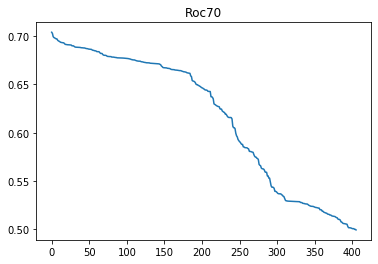

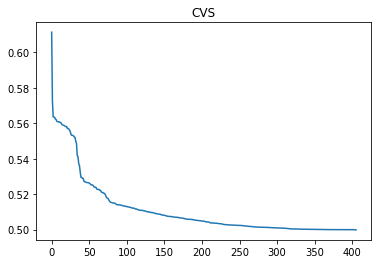

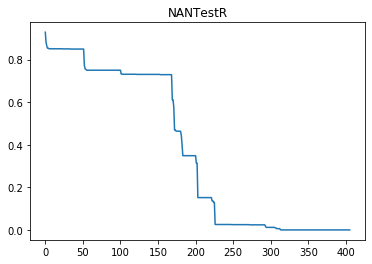

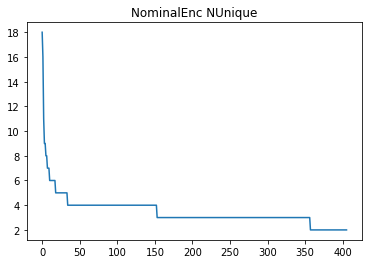

In [12]:
plt.title('Roc70')
plt.plot(results.Roc70.sort_values(ascending=False).values)
plt.show()

plt.title('CVS')
plt.plot(results.CVS.sort_values(ascending=False).values)
plt.show()

plt.title('NANTestR')
plt.plot(results.NANTestR.sort_values(ascending=False).values)
plt.show()

plt.title('NominalEnc NUnique')
plt.plot(cnts.values)
plt.show()

In [13]:
candidates = results[
    (results.Roc70 >= 0.6) &
    (results.NANTestR < 0.75) &
    (results.NANTrainR < 0.75) &
    (results.CVS <= 0.525) # perhaps allow this to increase?
].sort_values(['Roc70'], ascending=False)
candidates

,col,CVS,NUnique,NANTrainR,NANTestR,MFreqR,MFreqV,LFreqCnt,Gain70,Split70,Roc70,Iter70,YCorr,DTCorr,GPS70,enc_cnt
159,V94,0.507949,3,0.020458,0.023843,0.776303,0.0,18,10966.520264,2.0,0.704054,1.0,0.188407,0.032731,5483.260132,4
99,V34,0.514922,23,0.021318,0.024846,0.779786,0.0,1,10740.100571,3.0,0.702866,1.0,0.180301,0.052853,3580.033524,4
98,V33,0.511623,13,0.021318,0.024846,0.789384,0.0,1,10706.912949,3.0,0.699515,1.0,0.183486,0.045495,3568.970983,4
117,V52,0.509425,12,0.130142,0.151678,0.638929,0.0,1,26261.612976,6.0,0.698587,2.0,0.239469,0.031656,4376.935496,4
76,V11,0.500017,8,0.298909,0.348374,0.320882,0.0,2,3068.276772,3.0,0.698195,1.0,-0.071950,0.000383,1022.758924,4
75,V10,0.500000,6,0.298909,0.348374,0.322316,0.0,1,3077.535492,3.0,0.697621,1.0,-0.074658,-0.002397,1025.845164,4
139,V74,0.515381,11,0.021843,0.025457,0.774737,0.0,1,23244.150726,9.0,0.697248,3.0,0.185915,0.049865,2582.683414,4
116,V51,0.500000,9,0.130142,0.151678,0.645482,0.0,14,22463.070129,6.0,0.697186,2.0,0.223191,0.025454,3743.845022,4
22,C4,0.505160,1532,0.000005,0.000006,0.750484,0.0,1,49042.935898,9.0,0.695754,3.0,0.030382,-0.020949,5449.215100,4
144,V79,0.505233,8,0.020458,0.023843,0.785785,0.0,16,13470.569824,3.0,0.695097,1.0,0.194141,0.026337,4490.189941,4


In [14]:
candidates.sort_values('YCorr').tail()

,col,CVS,NUnique,NANTrainR,NANTestR,MFreqR,MFreqV,LFreqCnt,Gain70,Split70,Roc70,Iter70,YCorr,DTCorr,GPS70,enc_cnt
266,V201,0.508093,56,0.627080,0.730852,0.207866,1.0,1,70577.948006,18.0,0.693072,6.0,0.328005,0.014209,3920.997111,3
307,V242,0.500188,28,0.643416,0.749891,0.220237,1.0,1,54299.528364,9.0,0.674168,3.0,0.360590,-0.004558,6033.280929,3
309,V244,0.500754,34,0.643416,0.749891,0.220111,1.0,1,56026.150349,9.0,0.674848,3.0,0.364129,-0.005745,6225.127817,3
311,V246,0.501693,225,0.643416,0.749891,0.214001,1.0,1,52689.302122,6.0,0.677583,2.0,0.366878,0.023145,8781.550354,3
322,V257,0.501440,225,0.643416,0.749891,0.208121,1.0,1,73524.007118,18.0,0.678905,6.0,0.383060,0.022669,4084.667062,3
